In [3]:
!conda info --envs

# conda environments:
#
base                     C:\Users\SeongJin\anaconda3
capstone              *  C:\Users\SeongJin\anaconda3\envs\capstone
test                     C:\Users\SeongJin\anaconda3\envs\test



In [17]:
from bs4 import BeautifulSoup
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
import time

from tqdm import tqdm

In [66]:
def generate_box(obj):
    xmin=float(obj.find("xmin").text)
    ymin=float(obj.find("ymin").text)
    xmax=float(obj.find("xmax").text)
    ymax=float(obj.find("ymax").text)
    
    return [xmin,ymin,xmax,ymax]

In [67]:
def generate_label(obj):
    if obj.find("name").text=="Bicycle":
        return 0
    else : #킥보드 예정
        return 1

In [68]:
def generate_target(xml_file):
    f=open(xml_file,'rt',encoding='utf-8')
    soup=BeautifulSoup(f,"lxml")
    
    tag=soup.find_all("object")
    boxes=[]
    labels=[]
    
    for i in tag:
        boxes.append(generate_box(i))
        labels.append(generate_label(i))
        
    boxes=torch.as_tensor(boxes,dtype=torch.float32)
    labels=torch.as_tensor(labels,dtype=torch.int64)
    
    target={}
    target["boxes"]=boxes
    target["labels"]=labels
    
    return target

In [69]:
def plot_image(img,annotation):
    img=img.permute(1,2,0)
    
    fig,ax=plt.subplots(1)
    #rects=[]
    ax.imshow(img)
    for idx in range(len(annotation["boxes"])):
        xmin,ymin,xmax,ymax=annotation["boxes"][idx]
        
        if annotation["labels"][idx]==0:
            rect=patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='g',facecolor='none')
        else: #annotation["labels"]==1
            rect=patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='r',facecolor='none')
        
        ax.add_patch(rect)
    
        #rects.append(rect)
    
    #return img,rects
    plt.show()   

In [70]:
class AlbumentationDataset(Dataset):
    def __init__(self,img_list,xml_list,transform=None):
        #img_list: 이미지 경로명 리스트
        self.imgs=img_list
        self.transform=transform
        self.xmls=xml_list
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self,idx):
        img_path=self.imgs[idx]
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        target=generate_target(self.xmls[idx])
        
        #albumentation
        if self.transform:
            transformed=self.transform(image=image,bboxes=target['boxes'],labels=target['labels'])
            image=transformed['image']
            target={'boxes':transformed['bboxes'],'labels':transformed['labels']}
            
        target['boxes']=torch.as_tensor(target['boxes'],dtype=torch.float32)
        target['labels']=torch.as_tensor(target['labels'],dtype=torch.int64)
        

        #normalize
        image=image.float()
        image=image/255
        return image,target
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [71]:
albumentations_transform=albumentations.Compose([
    albumentations.RandomSizedBBoxSafeCrop(width=300,height=300,erosion_rate=0.1),
    albumentations.HorizontalFlip(p=1),
    albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc',label_fields=['labels']),
)

In [72]:
xml_path=r'G:\OIDv4_ToolKit-master\OID\Dataset\train\Bicycle\Label'
xml_path+="\*.xml"

img_path=r'G:\OIDv4_ToolKit-master\OID\Dataset\train\Bicycle'
img_path+="\*.jpg"

xml_list=glob.glob(xml_path)
img_list=glob.glob(img_path)



#validation
if len(xml_list)!=len(img_list):
    print(len(xml_list),len(img_list))
else:
    print("pass")

s_x=len(xml_path)+2
s_i=len(img_path)+2
for i in range(len(xml_list)):
    xml_name=xml_list[i][s_x:-4]
    img_name=img_list[i][s_i:-4]
    if(xml_name!=img_name):
        print('error',xml_name)


pass


In [73]:
f=open(xml_list[2],'r',encoding='utf-8')

soup=BeautifulSoup(f,"lxml")
    
tag=soup.find_all("bndbox")
print(tag)

[<bndbox><xmin>98</xmin><ymin>0</ymin><xmax>789</xmax><ymax>680</ymax></bndbox>]


torch.Size([3, 300, 300])
torch.FloatTensor
tensor([[[0.5216, 0.5294, 0.5294,  ..., 0.2431, 0.2078, 0.1686],
         [0.5176, 0.5255, 0.5373,  ..., 0.2745, 0.2431, 0.1922],
         [0.5294, 0.5373, 0.5373,  ..., 0.2745, 0.2549, 0.2078],
         ...,
         [0.1020, 0.1216, 0.1373,  ..., 0.3804, 0.3961, 0.3922],
         [0.0902, 0.1098, 0.1255,  ..., 0.3216, 0.3333, 0.3098],
         [0.0941, 0.1020, 0.1294,  ..., 0.2627, 0.3020, 0.2902]],

        [[0.5333, 0.5373, 0.5412,  ..., 0.2235, 0.1922, 0.1647],
         [0.5294, 0.5373, 0.5451,  ..., 0.2510, 0.2275, 0.1843],
         [0.5412, 0.5490, 0.5529,  ..., 0.2588, 0.2353, 0.2000],
         ...,
         [0.1176, 0.1451, 0.1686,  ..., 0.3882, 0.4235, 0.4196],
         [0.1020, 0.1255, 0.1529,  ..., 0.3216, 0.3412, 0.3255],
         [0.1059, 0.1176, 0.1529,  ..., 0.2667, 0.3098, 0.3059]],

        [[0.4902, 0.4941, 0.4980,  ..., 0.2235, 0.1882, 0.1569],
         [0.4863, 0.4902, 0.4941,  ..., 0.2510, 0.2235, 0.1843],
         [0.50

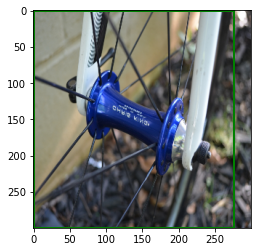

In [74]:
#test
albumentation_dataset=AlbumentationDataset(img_list=img_list,xml_list=xml_list,transform=albumentations_transform)

img,annot=albumentation_dataset[4]
print(img.size())
print(img.type())
print(img)
print(annot)
plot_image(img,annot)

In [82]:
def zero_box_check(dataset):
    
    zero_torch=torch.randn(0)
    img_idx=[]
    index=0
    for img,annot in tqdm(dataset):
        box=annot['boxes']
        if box.size()==zero_torch.shape:
            #print(img)
            #print(annot)
            #plot_image(img,annot)
            img_idx.append(index)
    
        index+=1
        
    return img_idx
        

In [76]:
#img path check
for img in tqdm(img_list):
    if not os.path.isfile(img):
        print(img)


100%|█████████████████████████████████████████████████████████████████████████| 17631/17631 [00:00<00:00, 88456.77it/s]


In [78]:
dataset=AlbumentationDataset(img_list=img_list,xml_list=xml_list,transform=albumentations_transform)
data_loader=torch.utils.data.DataLoader(dataset,batch_size=8, collate_fn=collate_fn)

In [83]:
#box data check
zero_index=zero_box_check(dataset)
for idx in zero_index:
    print(data_img_list[idx])

100%|████████████████████████████████████████████████████████████████████████████| 17631/17631 [03:23<00:00, 86.82it/s]


In [84]:
retina=torchvision.models.detection.retinanet_resnet50_fpn(num_classes=1,pretrained=False,pretrained_backbone=True)

In [85]:
#torch.cuda.is_available()
torch.cuda.empty_cache()

In [110]:
torch.cuda.empty_cache()
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_epochs=100
learning_rate=0.001
retina.to(device)

params=[p for p in retina.parameters() if p.requires_grad]
optimizer=torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

len_dataloader=len(data_loader)


for epoch in range(num_epochs):
    start=time.time()
    retina.train()
    
    zero=0
    i=0
    epoch_loss=0
    for images, targets in tqdm(data_loader):
        images=list(image.to(device) for image in images)
        targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
        
        #print(targets)
    
        #ignore zero target
        zero_torch=torch.randn(0)
        if targets[0]['boxes'].size()==zero_torch.shape:
            zero+=1
            continue
        
        loss_dict=retina(images,targets)
        
        losses=sum(loss for loss in loss_dict.values())
        
        i+=1
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss+=losses
        
    print(epoch,epoch_loss,f'time: {time.time()-start}')
        

100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:35<00:00,  1.78it/s]


0 tensor(717.6450, device='cuda:0', grad_fn=<AddBackward0>) time: 1236.2733113765717


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


1 tensor(693.8678, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.242653131485


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


2 tensor(685.5463, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.2086741924286


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


3 tensor(678.3001, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.2177364826202


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


4 tensor(676.1862, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.2193377017975


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


5 tensor(668.6407, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.139295578003


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


6 tensor(670.6890, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.2490096092224


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


7 tensor(663.8853, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.1378810405731


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


8 tensor(656.4709, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.1413252353668


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


9 tensor(662.3961, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.1324262619019


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


10 tensor(654.4033, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.2940487861633


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


11 tensor(654.7570, device='cuda:0', grad_fn=<AddBackward0>) time: 1233.9605875015259


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


12 tensor(656.2097, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.0818746089935


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


13 tensor(648.4814, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.0286111831665


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:38<00:00,  1.78it/s]


14 tensor(651.7231, device='cuda:0', grad_fn=<AddBackward0>) time: 1239.2329421043396


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


15 tensor(643.7886, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.3661830425262


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


16 tensor(643.0803, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.049484014511


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


17 tensor(640.6651, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.2370541095734


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


18 tensor(636.5198, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.0854156017303


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


19 tensor(642.7394, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.3194427490234


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


20 tensor(636.1279, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.0204555988312


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


21 tensor(633.3220, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.0986545085907


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


22 tensor(637.3069, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.0829792022705


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


23 tensor(631.5377, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.1004836559296


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


24 tensor(630.1626, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.1064007282257


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


25 tensor(630.0908, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.0250086784363


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


26 tensor(627.0671, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.0603737831116


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


27 tensor(621.5205, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.1592948436737


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


28 tensor(623.1740, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.1565346717834


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:52<00:00,  1.76it/s]


29 tensor(626.1382, device='cuda:0', grad_fn=<AddBackward0>) time: 1252.676104068756


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:50<00:00,  1.76it/s]


30 tensor(622.9107, device='cuda:0', grad_fn=<AddBackward0>) time: 1250.5149466991425


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


31 tensor(616.2369, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.0220663547516


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


32 tensor(619.3067, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.287724494934


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


33 tensor(620.3629, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.325854063034


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


34 tensor(617.4971, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.2805614471436


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


35 tensor(611.0938, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.343317270279


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


36 tensor(612.1364, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.3673338890076


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


37 tensor(603.3786, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.4277694225311


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


38 tensor(603.9844, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.3361830711365


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


39 tensor(644.1528, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.317762374878


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


40 tensor(621.9501, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.3363394737244


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:42<00:00,  1.77it/s]


41 tensor(607.5855, device='cuda:0', grad_fn=<AddBackward0>) time: 1242.4862248897552


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:35<00:00,  1.78it/s]


42 tensor(601.3058, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.4234125614166


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


43 tensor(600.0077, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.271873474121


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


44 tensor(595.3224, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.1265397071838


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


45 tensor(594.2882, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.296454668045


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


46 tensor(596.3348, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.232203245163


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


47 tensor(596.9000, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.2410192489624


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


48 tensor(601.7003, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.1709654331207


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


49 tensor(596.3325, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.2663695812225


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


50 tensor(594.7437, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.2543110847473


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


51 tensor(589.4111, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.1916477680206


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


52 tensor(582.9310, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.3168382644653


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:58<00:00,  1.75it/s]


53 tensor(597.1476, device='cuda:0', grad_fn=<AddBackward0>) time: 1258.5988211631775


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:47<00:00,  1.77it/s]


54 tensor(585.1551, device='cuda:0', grad_fn=<AddBackward0>) time: 1247.6422846317291


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


55 tensor(582.8948, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.3950402736664


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


56 tensor(574.8989, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.2718551158905


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


57 tensor(588.8585, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.4808945655823


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


58 tensor(588.2748, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.2365238666534


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


59 tensor(582.2932, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.1879053115845


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


60 tensor(574.0808, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.2842857837677


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


61 tensor(573.2864, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.1471314430237


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


62 tensor(566.0977, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.114863872528


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


63 tensor(572.4431, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.1759660243988


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.78it/s]


64 tensor(570.5500, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.236677646637


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [37:02<00:00,  1.01s/it]


65 tensor(561.3063, device='cuda:0', grad_fn=<AddBackward0>) time: 2223.203693628311


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [39:12<00:00,  1.07s/it]


66 tensor(564.1021, device='cuda:0', grad_fn=<AddBackward0>) time: 2353.185529232025


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [39:12<00:00,  1.07s/it]


67 tensor(564.0518, device='cuda:0', grad_fn=<AddBackward0>) time: 2353.2069890499115


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [39:12<00:00,  1.07s/it]


68 tensor(564.3295, device='cuda:0', grad_fn=<AddBackward0>) time: 2353.182019472122


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [39:17<00:00,  1.07s/it]


69 tensor(564.7939, device='cuda:0', grad_fn=<AddBackward0>) time: 2358.0540289878845


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [27:24<00:00,  1.34it/s]


70 tensor(573.9212, device='cuda:0', grad_fn=<AddBackward0>) time: 1644.9511029720306


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [21:30<00:00,  1.71it/s]


71 tensor(554.1918, device='cuda:0', grad_fn=<AddBackward0>) time: 1290.519006729126


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [21:08<00:00,  1.74it/s]


72 tensor(561.5824, device='cuda:0', grad_fn=<AddBackward0>) time: 1268.4523499011993


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:35<00:00,  1.78it/s]


73 tensor(562.8336, device='cuda:0', grad_fn=<AddBackward0>) time: 1235.7910528182983


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


74 tensor(574.8477, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.4279444217682


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


75 tensor(551.7614, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.595239162445


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


76 tensor(550.9897, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.4763007164001


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


77 tensor(548.6833, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.4494013786316


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


78 tensor(550.9384, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.4628672599792


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


79 tensor(542.6072, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.498348236084


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


80 tensor(544.1886, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.466450214386


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


81 tensor(548.7881, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.512511253357


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [21:01<00:00,  1.75it/s]


82 tensor(549.2352, device='cuda:0', grad_fn=<AddBackward0>) time: 1262.1604461669922


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [21:30<00:00,  1.71it/s]


83 tensor(549.5656, device='cuda:0', grad_fn=<AddBackward0>) time: 1291.3874506950378


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [22:03<00:00,  1.67it/s]


84 tensor(543.4055, device='cuda:0', grad_fn=<AddBackward0>) time: 1323.700406551361


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [21:32<00:00,  1.71it/s]


85 tensor(533.2750, device='cuda:0', grad_fn=<AddBackward0>) time: 1292.7431225776672


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [21:24<00:00,  1.72it/s]


86 tensor(568.7330, device='cuda:0', grad_fn=<AddBackward0>) time: 1285.1299993991852


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:49<00:00,  1.76it/s]


87 tensor(539.0807, device='cuda:0', grad_fn=<AddBackward0>) time: 1249.9822602272034


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:30<00:00,  1.79it/s]


88 tensor(576.3887, device='cuda:0', grad_fn=<AddBackward0>) time: 1230.8650686740875


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:30<00:00,  1.79it/s]


89 tensor(553.7216, device='cuda:0', grad_fn=<AddBackward0>) time: 1230.7544586658478


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


90 tensor(530.8011, device='cuda:0', grad_fn=<AddBackward0>) time: 1231.6682329177856


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:34<00:00,  1.79it/s]


91 tensor(555.4531, device='cuda:0', grad_fn=<AddBackward0>) time: 1234.9722645282745


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:37<00:00,  1.78it/s]


92 tensor(540.4702, device='cuda:0', grad_fn=<AddBackward0>) time: 1237.4664039611816


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:33<00:00,  1.79it/s]


93 tensor(536.6471, device='cuda:0', grad_fn=<AddBackward0>) time: 1233.699718952179


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


94 tensor(536.1475, device='cuda:0', grad_fn=<AddBackward0>) time: 1231.6473467350006


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


95 tensor(524.9332, device='cuda:0', grad_fn=<AddBackward0>) time: 1231.5540297031403


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


96 tensor(528.0631, device='cuda:0', grad_fn=<AddBackward0>) time: 1231.672472000122


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


97 tensor(519.9099, device='cuda:0', grad_fn=<AddBackward0>) time: 1231.6227555274963


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:32<00:00,  1.79it/s]


98 tensor(519.9005, device='cuda:0', grad_fn=<AddBackward0>) time: 1232.610419511795


100%|██████████████████████████████████████████████████████████████████████████████| 2204/2204 [20:31<00:00,  1.79it/s]


99 tensor(528.4623, device='cuda:0', grad_fn=<AddBackward0>) time: 1231.5967361927032


In [111]:
torch.save(retina.state_dict(),f'retina_{num_epochs}_{learning_rate}_OID.pt')

In [ ]:
#retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))
retina.load_state_dict(torch.load(f'retina_70_0.0001.pt'))
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

In [112]:
def make_prediction(model,img,threshold):
    model.eval()
    preds=model(img)
    for id in range(len(preds)):
        idx_list=[]
        
        for idx,score in enumerate(preds[id]['scores']):
            if score>threshold:
                idx_list.append(idx)
                
        preds[id]['boxes']=preds[id]['boxes'][idx_list]
        preds[id]['labels']=preds[id]['labels'][idx_list]
        preds[id]['scores']=preds[id]['scores'][idx_list]
        
        
    return preds


In [113]:
test_xml_path=r'G:\OIDv4_ToolKit-master\OID\Dataset\test\Bicycle\Label'
test_xml_path+="\*.xml"

test_img_path=r'G:\OIDv4_ToolKit-master\OID\Dataset\test\Bicycle'
test_img_path+="\*.jpg"

test_xml_list=glob.glob(test_xml_path)
test_img_list=glob.glob(test_img_path)

In [114]:
test_dataset=AlbumentationDataset(img_list=test_img_list,xml_list=test_xml_list,transform=albumentations_transform)
test_data_loader=torch.utils.data.DataLoader(test_dataset,batch_size=8, collate_fn=collate_fn)

In [115]:
labels=[]
preds_adj_all=[]
annot_all=[]

for im,annot in tqdm(test_data_loader,position=0,leave=True):
    im=list(img.to(device) for img in im)
    
    for t in annot:
        labels+=t['labels']
        
    with torch.no_grad():
        preds_adj=make_prediction(retina,im,0.5)
        preds_adj=[{k:v.to(torch.device('cpu')) for k,v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:34<00:00,  2.57it/s]


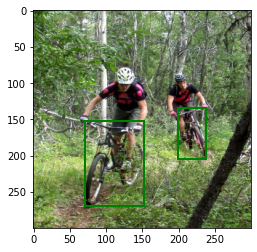

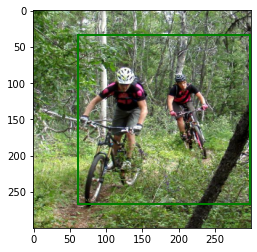

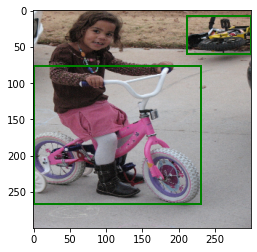

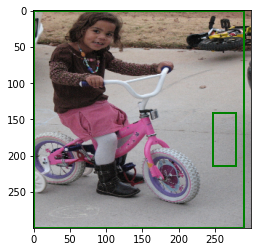

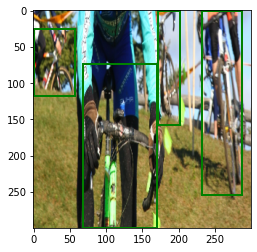

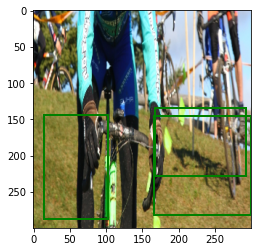

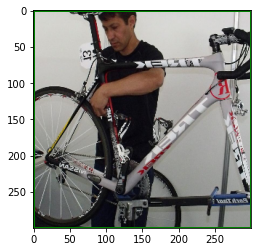

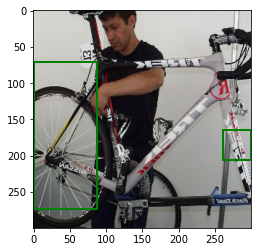

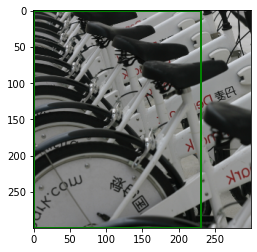

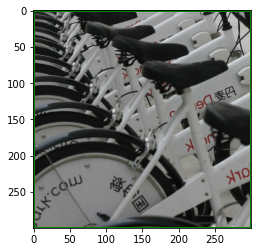

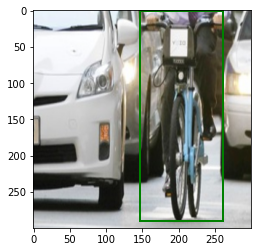

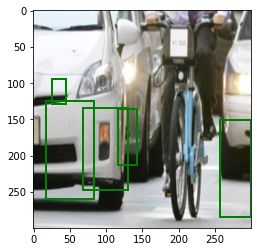

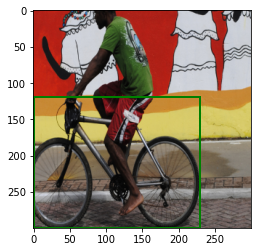

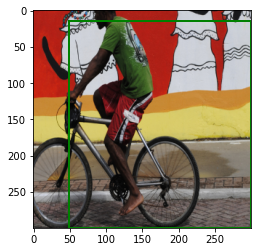

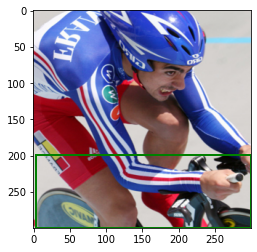

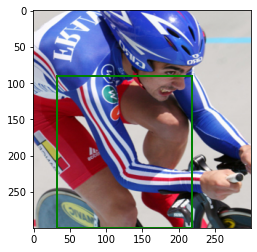

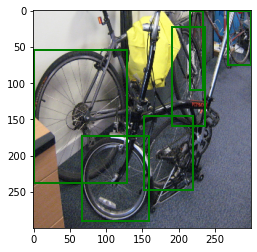

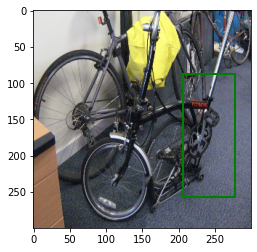

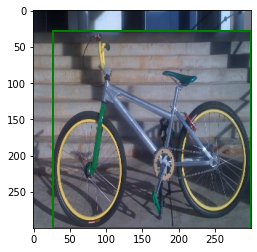

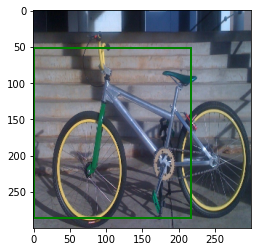

In [116]:
import random

total=range(len(test_data_loader))
select=random.sample(total,10);

for i in select:
    test_annot=annot_all[i][0]
    img,annot=test_dataset[i]

    plot_image(img,annot)
    plot_image(img,test_annot)

In [117]:
import utils_ObjectDetection as utils

In [118]:
sample_metrics=[]
for batch_i in range(len(preds_adj_all)):
    sample_metrics+=utils.get_batch_statistics(preds_adj_all[batch_i],annot_all[batch_i],iou_threshold=0.5)
    
true_positives,pred_scores,pred_labels=[torch.cat(x,0) for x in list(zip(*sample_metrics))]
precision,recall,AP,f1,ap_class=utils.ap_per_class(true_positives,pred_scores,pred_labels,torch.tensor(labels))
mAP=torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.6906846739436919
AP : tensor([0.6907], dtype=torch.float64)
